In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F  
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from collections import Counter
import seaborn as sns


Files already downloaded and verified
Files already downloaded and verified


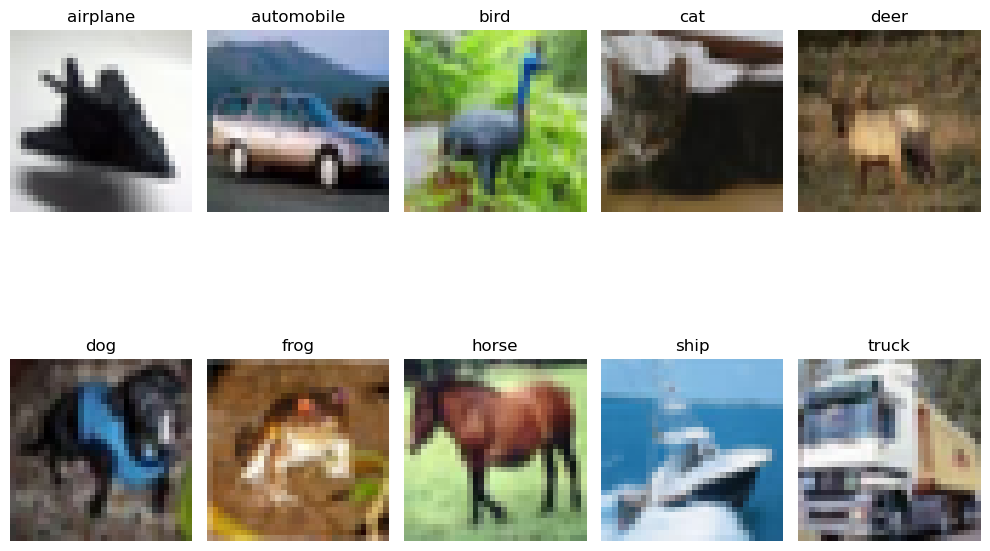

Files already downloaded and verified


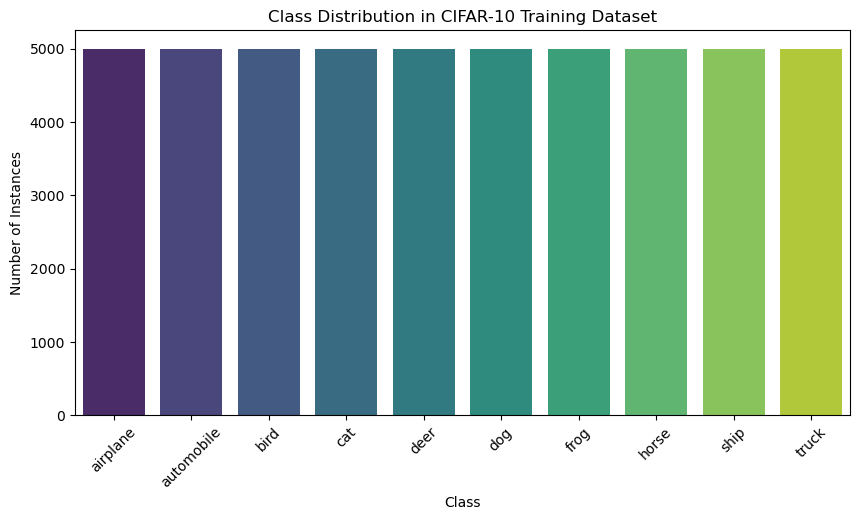

Training set size: 40000
Validation set size: 10000
Test set size: 10000


In [8]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
])

# Download and load the training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the trainset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(trainset))  # 80% of training data
valid_size = len(trainset) - train_size  # 20% of validation data

# CIFAR-10 class labels
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                'dog', 'frog', 'horse', 'ship', 'truck']

# Create a figure to display the images
plt.figure(figsize=(10, 8))

# Iterate through each class and display one image
for class_index in range(10):
    # Find the first image of the class
    for j in range(len(trainset)):
        if trainset.targets[j] == class_index: 
            image, _ = trainset[j]
            plt.subplot(2, 5, class_index + 1)
            plt.imshow(image.permute(1, 2, 0) / 2 + 0.5) 
            plt.title(class_labels[class_index])
            plt.axis('off')
            break  

plt.tight_layout()
plt.show()

train_data = CIFAR10(root='./data', train=True, download=True)
labels = [train_data.targets[i] for i in range(len(train_data))]
label_counts = Counter(labels)
class_names = train_data.classes
class_counts = [label_counts[i] for i in range(10)]

# Plot the distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=class_names, y=class_counts, palette="viridis")
plt.title("Class Distribution in CIFAR-10 Training Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.xticks(rotation=45)
plt.show()
trainset, validationset = torch.utils.data.random_split(trainset, [train_size, valid_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=64, shuffle=False, num_workers=2)

# Check the size of the dataset
print('Training set size:', len(trainset))
print('Validation set size:', len(validationset))
print('Test set size:', len(testset))

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch [1/10], Train Loss: 1.4846, Train Acc: 0.4619, Valid Loss: 1.2338, Valid Acc: 0.5589
Epoch [2/10], Train Loss: 1.0846, Train Acc: 0.6151, Valid Loss: 1.0127, Valid Acc: 0.6508
Epoch [3/10], Train Loss: 0.8990, Train Acc: 0.6850, Valid Loss: 0.9098, Valid Acc: 0.6820
Epoch [4/10], Train Loss: 0.7788, Train Acc: 0.7273, Valid Loss: 0.8473, Valid Acc: 0.7056
Epoch [5/10], Train Loss: 0.6816, Train Acc: 0.7624, Valid Loss: 0.8042, Valid Acc: 0.7211
Epoch [6/10], Train Loss: 0.5983, Train Acc: 0.7915, Valid Loss: 0.8400, Valid Acc: 0.7180
Epoch [7/10], Train Loss: 0.5247, Train Acc: 0.8149, Valid Loss: 0.8303, Valid Acc: 0.7288
Epoch [8/10], Train Loss: 0.4583, Train Acc: 0.8383, Valid Loss: 0.8561, Valid Acc: 0.7233
Epoch [9/10], Train Loss: 0.3950, Train Acc: 0.8616, Valid Loss: 0.8645, Valid Acc: 0.7313
Epoch [10/10], Train Loss: 0.3374, Train Acc: 0.8808, Valid Loss: 0.9603, Valid Acc: 0.7229


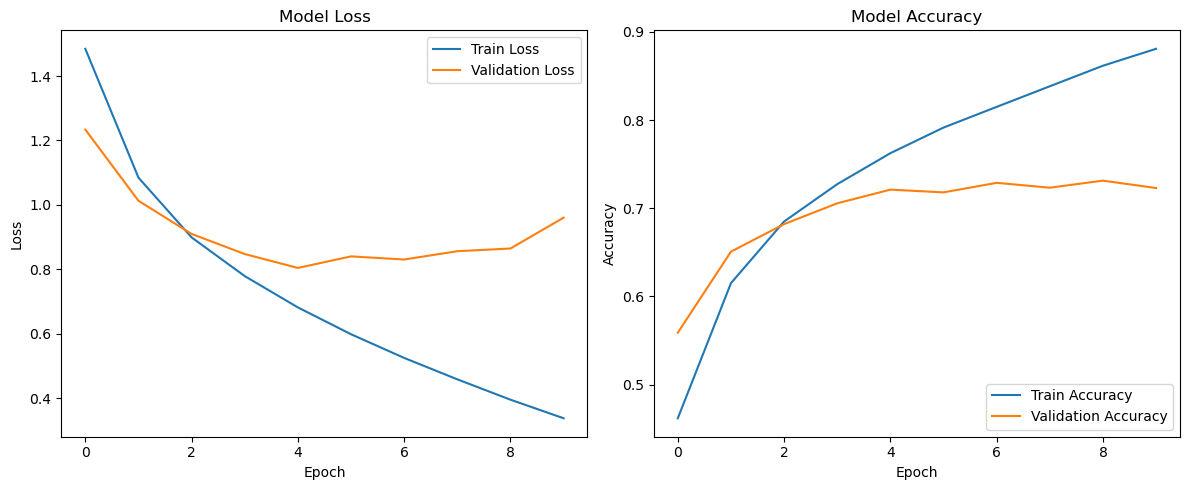

In [3]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Initialize the model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss and accuracy
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Training loop
for epoch in range(10):  
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = running_loss / len(trainloader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in validationloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    valid_loss = running_loss / len(validationloader)
    valid_accuracy = correct / total
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

Epoch [1/10], Train Loss: 1.4322, Train Acc: 0.4846, Valid Loss: 1.3044, Valid Acc: 0.5392
Epoch [2/10], Train Loss: 1.0458, Train Acc: 0.6306, Valid Loss: 0.9732, Valid Acc: 0.6600
Epoch [3/10], Train Loss: 0.8635, Train Acc: 0.7000, Valid Loss: 0.9464, Valid Acc: 0.6718
Epoch [4/10], Train Loss: 0.7255, Train Acc: 0.7494, Valid Loss: 0.8861, Valid Acc: 0.6957
Epoch [5/10], Train Loss: 0.6184, Train Acc: 0.7834, Valid Loss: 0.7621, Valid Acc: 0.7359
Epoch [6/10], Train Loss: 0.5247, Train Acc: 0.8179, Valid Loss: 0.7848, Valid Acc: 0.7399
Epoch [7/10], Train Loss: 0.4358, Train Acc: 0.8462, Valid Loss: 0.8279, Valid Acc: 0.7356
Epoch [8/10], Train Loss: 0.3589, Train Acc: 0.8737, Valid Loss: 0.8444, Valid Acc: 0.7456
Epoch [9/10], Train Loss: 0.2763, Train Acc: 0.9030, Valid Loss: 0.8409, Valid Acc: 0.7507
Epoch [10/10], Train Loss: 0.2320, Train Acc: 0.9186, Valid Loss: 0.8974, Valid Acc: 0.7433


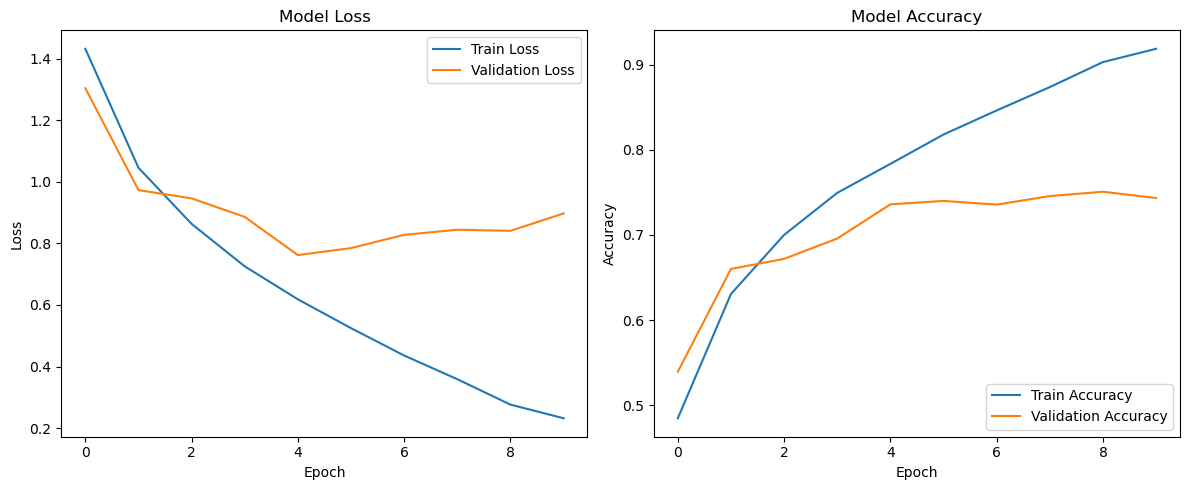

In [24]:
import torchvision.models as models
# Define a ResNet18 model
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet18 = models.resnet18(weights=None)
        
        # Replace the final layer
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, 10)

    def forward(self, x):
        return self.resnet18(x)


# Initialize the model, loss function, and optimizer
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss and accuracy
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Training loop
for epoch in range(10):  
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = running_loss / len(trainloader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in validationloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    valid_loss = running_loss / len(validationloader)
    valid_accuracy = correct / total
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

Epoch [1/10], Train Loss: 1.7831, Train Acc: 0.3660, Valid Loss: 1.4237, Valid Acc: 0.4824
Epoch [2/10], Train Loss: 1.2840, Train Acc: 0.5392, Valid Loss: 1.1115, Valid Acc: 0.6091
Epoch [3/10], Train Loss: 1.0374, Train Acc: 0.6322, Valid Loss: 1.0343, Valid Acc: 0.6331
Epoch [4/10], Train Loss: 0.8826, Train Acc: 0.6915, Valid Loss: 0.8508, Valid Acc: 0.7010
Epoch [5/10], Train Loss: 0.7596, Train Acc: 0.7352, Valid Loss: 0.8479, Valid Acc: 0.7084
Epoch [6/10], Train Loss: 0.6682, Train Acc: 0.7670, Valid Loss: 0.8166, Valid Acc: 0.7244
Epoch [7/10], Train Loss: 0.5788, Train Acc: 0.7984, Valid Loss: 0.7566, Valid Acc: 0.7412
Epoch [8/10], Train Loss: 0.4866, Train Acc: 0.8305, Valid Loss: 0.8001, Valid Acc: 0.7466
Epoch [9/10], Train Loss: 0.4133, Train Acc: 0.8566, Valid Loss: 0.8286, Valid Acc: 0.7355
Epoch [10/10], Train Loss: 0.3372, Train Acc: 0.8803, Valid Loss: 0.8386, Valid Acc: 0.7454


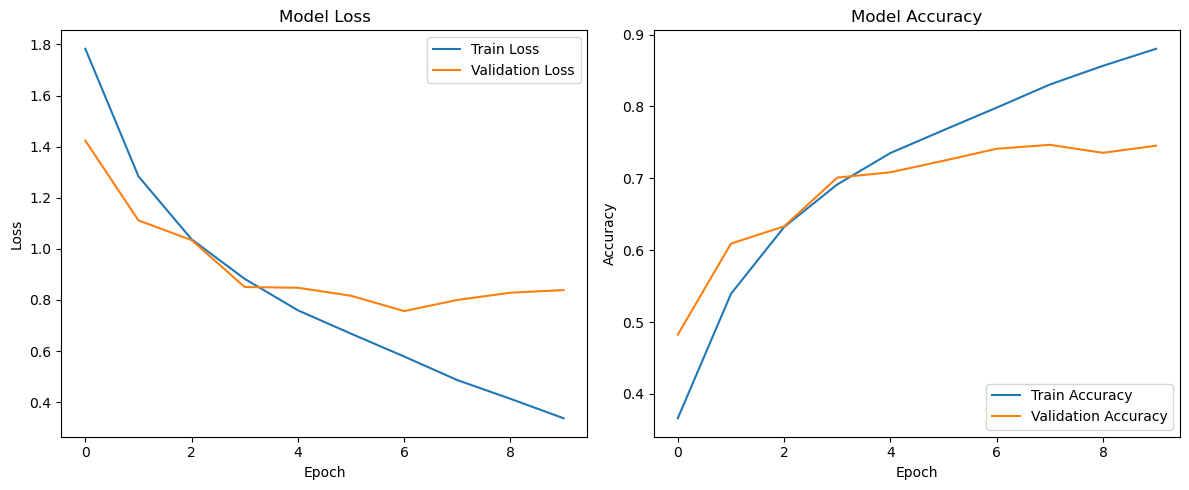

In [9]:
import torchvision.models as models
# Define a ResNet18 model
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet18 = models.resnet18(weights=None)
        
        # Replace the final layer
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, 10)

    def forward(self, x):
        return self.resnet18(x)


# Initialize the model, loss function, and optimizer
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Lists to store loss and accuracy
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Training loop
for epoch in range(10):  
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = running_loss / len(trainloader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in validationloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    valid_loss = running_loss / len(validationloader)
    valid_accuracy = correct / total
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

Epoch [1/10], Train Loss: 2.1238, Train Acc: 0.2273, Valid Loss: 1.8373, Valid Acc: 0.2713
Epoch [2/10], Train Loss: 1.7242, Train Acc: 0.3092, Valid Loss: 1.8694, Valid Acc: 0.3133
Epoch [3/10], Train Loss: 1.6189, Train Acc: 0.3708, Valid Loss: 1.5753, Valid Acc: 0.4117
Epoch [4/10], Train Loss: 1.5361, Train Acc: 0.4226, Valid Loss: 1.5477, Valid Acc: 0.4512
Epoch [5/10], Train Loss: 1.4716, Train Acc: 0.4552, Valid Loss: 1.4056, Valid Acc: 0.4977


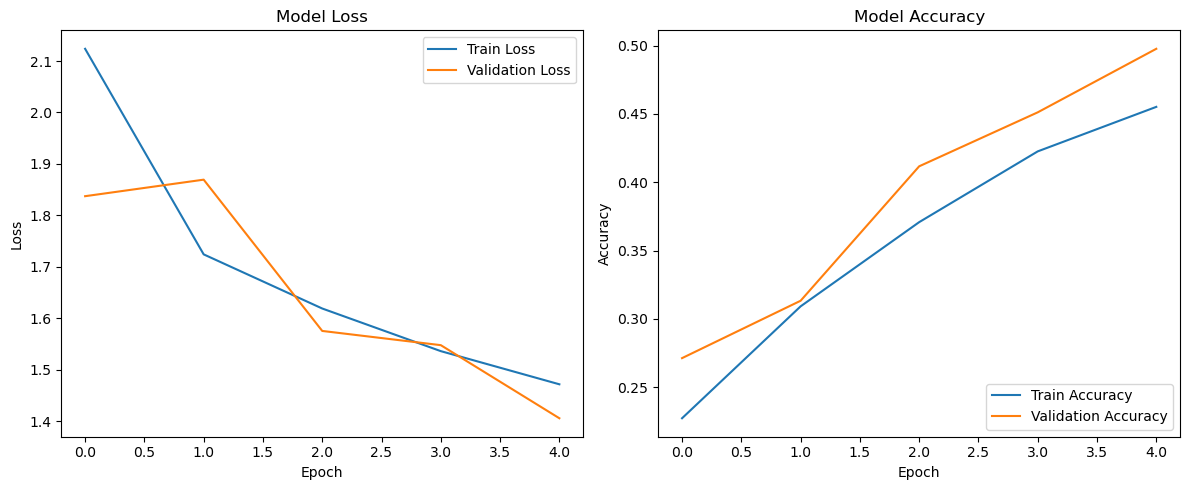

In [11]:
import torchvision.models as models
# Define a ResNet18 model
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet18 = models.resnet18(weights=None)
        
        # Replace the final layer
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, 10)

    def forward(self, x):
        return self.resnet18(x)


# Initialize the model, loss function, and optimizer
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Lists to store loss and accuracy
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Training loop
for epoch in range(5):  
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = running_loss / len(trainloader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in validationloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    valid_loss = running_loss / len(validationloader)
    valid_accuracy = correct / total
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

Epoch [1/10], Train Loss: 1.6177, Train Acc: 0.4151, Valid Loss: 1.4072, Valid Acc: 0.4918
Epoch [2/10], Train Loss: 1.2710, Train Acc: 0.5422, Valid Loss: 1.2965, Valid Acc: 0.5414
Epoch [3/10], Train Loss: 1.0795, Train Acc: 0.6158, Valid Loss: 1.2182, Valid Acc: 0.5721
Epoch [4/10], Train Loss: 0.9232, Train Acc: 0.6707, Valid Loss: 1.1356, Valid Acc: 0.6048
Epoch [5/10], Train Loss: 0.7905, Train Acc: 0.7198, Valid Loss: 1.1443, Valid Acc: 0.6207
Epoch [6/10], Train Loss: 0.6532, Train Acc: 0.7683, Valid Loss: 1.2080, Valid Acc: 0.6087
Epoch [7/10], Train Loss: 0.5320, Train Acc: 0.8119, Valid Loss: 1.2285, Valid Acc: 0.6148
Epoch [8/10], Train Loss: 0.4357, Train Acc: 0.8459, Valid Loss: 1.2488, Valid Acc: 0.6292
Epoch [9/10], Train Loss: 0.3434, Train Acc: 0.8792, Valid Loss: 1.2941, Valid Acc: 0.6357
Epoch [10/10], Train Loss: 0.2698, Train Acc: 0.9064, Valid Loss: 1.3722, Valid Acc: 0.6308


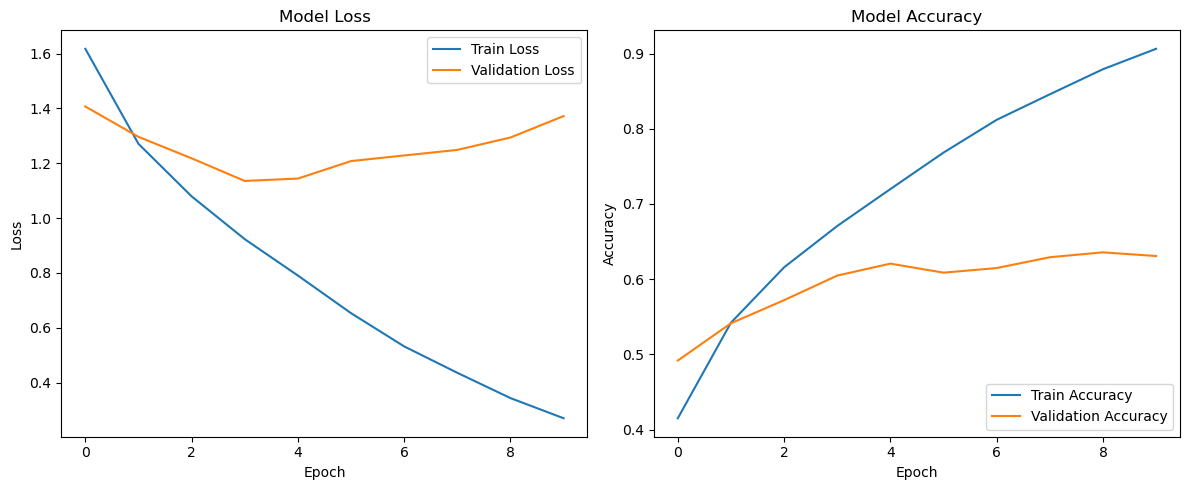

In [12]:
import torchvision.models as models
# Define a ResNet18 model
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet18 = models.resnet18(weights=None)
        
        # Replace the final layer
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, 10)

    def forward(self, x):
        return self.resnet18(x)


# Initialize the model, loss function, and optimizer
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Lists to store loss and accuracy
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

best_valid_loss = float('inf')
epochs_without_improvement = 0
# Training loop
for epoch in range(10):  
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = running_loss / len(trainloader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in validationloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    valid_loss = running_loss / len(validationloader)
    valid_accuracy = correct / total
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')
    
    # Early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_without_improvement = 0
        
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= 2:
            print("Early stopping...")
            break

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

Epoch [1/10], Train Loss: 1.9811, Train Acc: 0.2752, Valid Loss: 1.7367, Valid Acc: 0.3651
Epoch [2/10], Train Loss: 1.6403, Train Acc: 0.4018, Valid Loss: 1.5635, Valid Acc: 0.4250
Epoch [3/10], Train Loss: 1.4976, Train Acc: 0.4537, Valid Loss: 1.4837, Valid Acc: 0.4615
Epoch [4/10], Train Loss: 1.3957, Train Acc: 0.4939, Valid Loss: 1.4242, Valid Acc: 0.4845
Epoch [5/10], Train Loss: 1.3067, Train Acc: 0.5270, Valid Loss: 1.3941, Valid Acc: 0.4972
Epoch [6/10], Train Loss: 1.2342, Train Acc: 0.5568, Valid Loss: 1.3686, Valid Acc: 0.5081
Epoch [7/10], Train Loss: 1.1708, Train Acc: 0.5813, Valid Loss: 1.3357, Valid Acc: 0.5201
Epoch [8/10], Train Loss: 1.1047, Train Acc: 0.6089, Valid Loss: 1.3170, Valid Acc: 0.5291
Epoch [9/10], Train Loss: 1.0412, Train Acc: 0.6319, Valid Loss: 1.3027, Valid Acc: 0.5377
Epoch [10/10], Train Loss: 0.9798, Train Acc: 0.6564, Valid Loss: 1.2966, Valid Acc: 0.5405


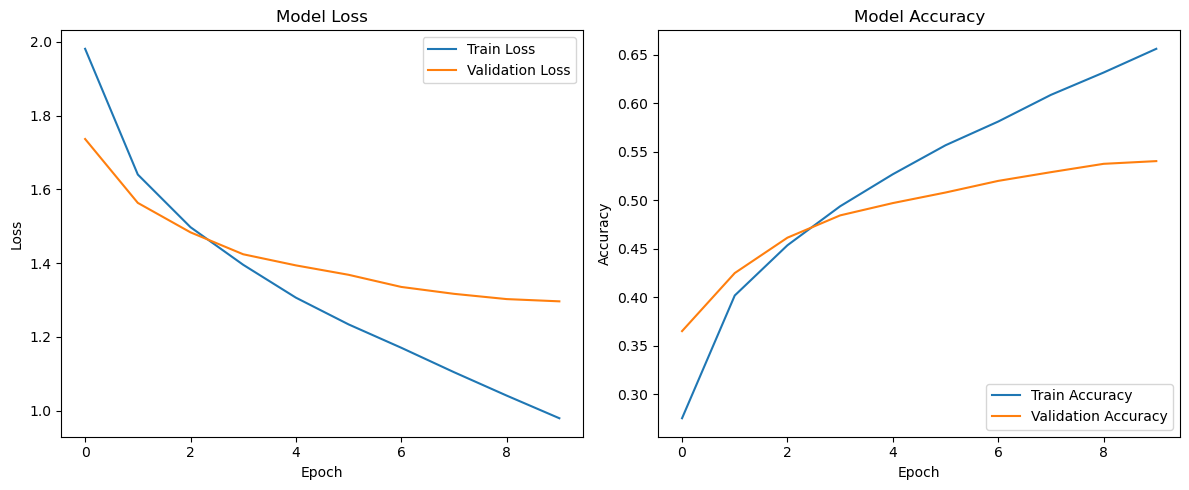

In [13]:
import torchvision.models as models
# Define a ResNet18 model
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet18 = models.resnet18(weights=None)
        
        # Replace the final layer
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, 10)

    def forward(self, x):
        return self.resnet18(x)


# Initialize the model, loss function, and optimizer
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Lists to store loss and accuracy
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

best_valid_loss = float('inf')
epochs_without_improvement = 0
# Training loop
for epoch in range(10):  
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = running_loss / len(trainloader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in validationloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    valid_loss = running_loss / len(validationloader)
    valid_accuracy = correct / total
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')
    
    # Early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_without_improvement = 0
        
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= 2:
            print("Early stopping...")
            break

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [16]:
# Define a transform to normalize the data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0)
])

# Download and load the training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./tans-data', train=True, download=True, transform=train_transforms)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the trainset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(trainset))  # 80% of training data
valid_size = len(trainset) - train_size  # 20% of validation data

trainset, validationset = torch.utils.data.random_split(trainset, [train_size, valid_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=64, shuffle=False, num_workers=2)

# Check the size of the dataset
print('Training set size:', len(trainset))
print('Validation set size:', len(validationset))
print('Test set size:', len(testset))

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Validation set size: 10000
Test set size: 10000


Epoch [1/10], Train Loss: 2.0924, Train Acc: 0.2429, Valid Loss: 1.8746, Valid Acc: 0.2952
Epoch [2/10], Train Loss: 1.8452, Train Acc: 0.3165, Valid Loss: 1.7669, Valid Acc: 0.3495
Epoch [3/10], Train Loss: 1.7635, Train Acc: 0.3527, Valid Loss: 1.7707, Valid Acc: 0.3621
Epoch [4/10], Train Loss: 1.6810, Train Acc: 0.3854, Valid Loss: 1.7135, Valid Acc: 0.3914
Epoch [5/10], Train Loss: 1.6006, Train Acc: 0.4222, Valid Loss: 1.5802, Valid Acc: 0.4266
Epoch [6/10], Train Loss: 1.5286, Train Acc: 0.4462, Valid Loss: 1.4971, Valid Acc: 0.4636
Epoch [7/10], Train Loss: 1.4717, Train Acc: 0.4720, Valid Loss: 1.4862, Valid Acc: 0.4741
Epoch [8/10], Train Loss: 1.4332, Train Acc: 0.4874, Valid Loss: 1.4378, Valid Acc: 0.5005
Epoch [9/10], Train Loss: 1.3893, Train Acc: 0.5033, Valid Loss: 1.3769, Valid Acc: 0.5099
Epoch [10/10], Train Loss: 1.3628, Train Acc: 0.5178, Valid Loss: 1.3714, Valid Acc: 0.5111
Epoch [11/10], Train Loss: 1.3380, Train Acc: 0.5252, Valid Loss: 1.3415, Valid Acc: 0.52

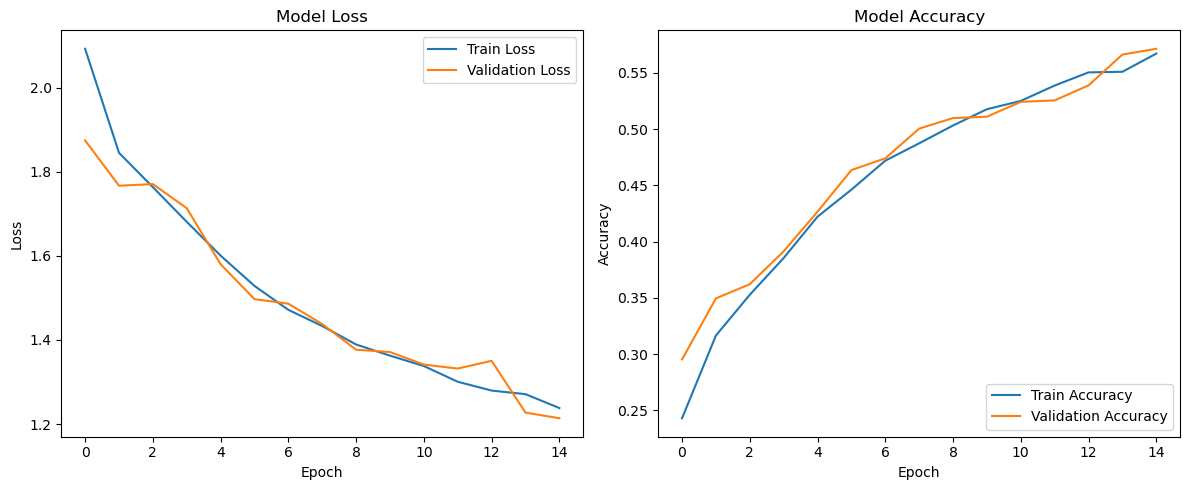

In [17]:
import torchvision.models as models
# Define a ResNet18 model
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet18 = models.resnet18(weights=None)
        
        # Replace the final layer
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, 10)

    def forward(self, x):
        return self.resnet18(x)


# Initialize the model, loss function, and optimizer
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Lists to store loss and accuracy
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

best_valid_loss = float('inf')
epochs_without_improvement = 0
# Training loop
for epoch in range(15):  
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = running_loss / len(trainloader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in validationloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    valid_loss = running_loss / len(validationloader)
    valid_accuracy = correct / total
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')
    
    # Early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_without_improvement = 0
        
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= 2:
            print("Early stopping...")
            break

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [19]:
# Test phase
model.eval()
running_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
# Calculate validation loss and accuracy
test_loss = running_loss / len(testloader)
test_accuracy = correct / total
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')

Test Loss: 0.8889, Test Acc: 0.6988
